<h1>Spark GraphX</h1>

In [1]:
import pandas as pd

import findspark
from pyspark.sql import SparkSession
from graphframes import GraphFrame
from pyspark.sql import SQLContext
from pyspark import SparkContext

findspark.init()

sc = SparkContext()
sqlContext = SQLContext(sc)

spark = SparkSession.builder.appName('project').getOrCreate()

<b>Generate a new RDD containing few selected US airport information, such as: (“BWI”, “Baltimore Washington Airport”, “JFK”, “NYC Airport”, “MIA”, “Miami Airport”, “LAX”, “Los Angeles Airport”, etc.)

<b>Limit your airport selection to 10 airports

In [2]:
airports = ['BWI', 'Baltimore Washington Airport', 'JFK', 'NYC Airport', 'MIA', 'Miami Airport', 'LAX', 'Los Angeles Airport', 'MHK', 'Manhattan Regional Airport', 
           'EUG', 'Eugene Airport', 'STL', 'St. Louis Lambert', 'CGI', 'Cape Girardeau', 'FWA', 'Fort Wayne', 'ORD', 'Chicago OHare']

In [3]:
#creating 2 lists of full and abbreviations to build the dataframe
air_abbr = []
air_full = []
for i in airports:
    if len(i) == 3:
        air_abbr.append(i)
    else:
        air_full.append(i)

In [4]:
air_abbr

['BWI', 'JFK', 'MIA', 'LAX', 'MHK', 'EUG', 'STL', 'CGI', 'FWA', 'ORD']

In [5]:
air_full

['Baltimore Washington Airport',
 'NYC Airport',
 'Miami Airport',
 'Los Angeles Airport',
 'Manhattan Regional Airport',
 'Eugene Airport',
 'St. Louis Lambert',
 'Cape Girardeau',
 'Fort Wayne',
 'Chicago OHare']

In [6]:
dictionary = dict(zip(air_abbr, air_full))
print(dictionary)

{'BWI': 'Baltimore Washington Airport', 'JFK': 'NYC Airport', 'MIA': 'Miami Airport', 'LAX': 'Los Angeles Airport', 'MHK': 'Manhattan Regional Airport', 'EUG': 'Eugene Airport', 'STL': 'St. Louis Lambert', 'CGI': 'Cape Girardeau', 'FWA': 'Fort Wayne', 'ORD': 'Chicago OHare'}


In [7]:
airports_DF = pd.DataFrame(dictionary.items(), columns=['id', 'Airport Name'])

In [8]:
airports_DF

,id,Airport Name
0,BWI,Baltimore Washington Airport
1,JFK,NYC Airport
2,MIA,Miami Airport
3,LAX,Los Angeles Airport
4,MHK,Manhattan Regional Airport
5,EUG,Eugene Airport
6,STL,St. Louis Lambert
7,CGI,Cape Girardeau
8,FWA,Fort Wayne
9,ORD,Chicago OHare


<b>Generate random data for flights between two random airports (selected from the RDD above). Random data generated can be in the form (src, dst, flight number), (“BWI”, “LAX”, “1552”), etc.

<b>You may use similar algorithm from the previous homework, make sure you generate 200+ flights (if you have a randomize function that generates one flight data information, then call the function 200 times)

In [9]:
edges = pd.DataFrame(columns=('src'
    , 'dst'
    , 'flight_num'
    ))

In [10]:
air_abbr_rdd = sc.parallelize(air_abbr) #rdd from abbr list

In [11]:
from random import randint #populating edges DF with 200 instances

for i in range(200):
    airports = air_abbr_rdd.takeSample(False, 2)
    flight_num = randint(100, 9999)
    
    data = [airports[0]
        , airports[1]
        , flight_num
        ]
    edges.loc[i] = [item for item in data]

In [12]:
edge_df = spark.createDataFrame(edges) #edges to spark DF
edge_df.show()

+---+---+----------+
|src|dst|flight_num|
+---+---+----------+
|JFK|ORD|       713|
|ORD|BWI|      4022|
|JFK|MIA|      5106|
|MIA|MHK|       590|
|LAX|EUG|      3065|
|EUG|MIA|      4168|
|MHK|CGI|      4281|
|EUG|JFK|      4350|
|MHK|EUG|      1131|
|STL|MIA|      2051|
|EUG|LAX|      7025|
|ORD|EUG|      7456|
|FWA|BWI|      5864|
|BWI|EUG|      7523|
|EUG|BWI|      2464|
|CGI|ORD|      9946|
|STL|FWA|      9804|
|MHK|LAX|      1909|
|ORD|LAX|      7075|
|JFK|FWA|      8995|
+---+---+----------+
only showing top 20 rows



In [13]:
airports_DF_spark = spark.createDataFrame(airports_DF)
airports_DF_spark.show()

+---+--------------------+
| id|        Airport Name|
+---+--------------------+
|BWI|Baltimore Washing...|
|JFK|         NYC Airport|
|MIA|       Miami Airport|
|LAX| Los Angeles Airport|
|MHK|Manhattan Regiona...|
|EUG|      Eugene Airport|
|STL|   St. Louis Lambert|
|CGI|      Cape Girardeau|
|FWA|          Fort Wayne|
|ORD|       Chicago OHare|
+---+--------------------+



In [14]:
Air_edge = edge_df.join(airports_DF_spark, edge_df.src == airports_DF_spark.id).drop(edge_df.src).drop(edge_df.dst).drop(edge_df.flight_num)

In [15]:
#counting number of flights, leaving only distinct values
from pyspark.sql.functions import countDistinct

countIncomingDF = edge_df.select("src", "dst")\
  .groupBy("src")\
  .agg(countDistinct("dst").alias("Incoming Flights"))

countOutgoingDF = edge_df.select("dst", "src")\
  .groupBy("dst")\
  .agg(countDistinct("src").alias("Outgoing Flights"))

countOutgoingDF.show()
countIncomingDF.show()

+---+----------------+
|dst|Outgoing Flights|
+---+----------------+
|EUG|               9|
|CGI|               8|
|MIA|               9|
|BWI|               9|
|STL|               6|
|MHK|               9|
|ORD|               8|
|FWA|               8|
|LAX|               8|
|JFK|               8|
+---+----------------+

+---+----------------+
|src|Incoming Flights|
+---+----------------+
|EUG|               9|
|CGI|               8|
|MIA|               7|
|BWI|               9|
|STL|               9|
|MHK|               7|
|ORD|               8|
|FWA|               7|
|LAX|               9|
|JFK|               9|
+---+----------------+



In [16]:
#building the Dataframe
Air_edge = Air_edge.join(countIncomingDF, Air_edge.id == countIncomingDF.src).distinct()

In [17]:
Air_edge = Air_edge.join(countOutgoingDF, Air_edge.id == countOutgoingDF.dst).distinct()

In [18]:
Air_edge.show()

+---+--------------------+---+----------------+---+----------------+
| id|        Airport Name|src|Incoming Flights|dst|Outgoing Flights|
+---+--------------------+---+----------------+---+----------------+
|EUG|      Eugene Airport|EUG|               9|EUG|               9|
|CGI|      Cape Girardeau|CGI|               8|CGI|               8|
|MIA|       Miami Airport|MIA|               7|MIA|               9|
|BWI|Baltimore Washing...|BWI|               9|BWI|               9|
|STL|   St. Louis Lambert|STL|               9|STL|               6|
|MHK|Manhattan Regiona...|MHK|               7|MHK|               9|
|ORD|       Chicago OHare|ORD|               8|ORD|               8|
|FWA|          Fort Wayne|FWA|               7|FWA|               8|
|LAX| Los Angeles Airport|LAX|               9|LAX|               8|
|JFK|         NYC Airport|JFK|               9|JFK|               8|
+---+--------------------+---+----------------+---+----------------+



In [19]:
pandas_df = Air_edge.toPandas() #converting to pandas to delete unnecessary columns without getting an error

In [20]:
pandas_df = pandas_df.drop(['src', 'dst'], axis=1) #nodes are ready

In [21]:
nodes_df = spark.createDataFrame(pandas_df) #converting back to spark to build the graph

<b>Generate the relationship graph

In [22]:
g = GraphFrame(nodes_df, edge_df)

In [23]:
# Take a look at the vertices and edges
g.vertices.show()
g.edges.show()

+---+--------------------+----------------+----------------+
| id|        Airport Name|Incoming Flights|Outgoing Flights|
+---+--------------------+----------------+----------------+
|EUG|      Eugene Airport|               9|               9|
|CGI|      Cape Girardeau|               8|               8|
|MIA|       Miami Airport|               7|               9|
|BWI|Baltimore Washing...|               9|               9|
|STL|   St. Louis Lambert|               9|               6|
|MHK|Manhattan Regiona...|               7|               9|
|ORD|       Chicago OHare|               8|               8|
|FWA|          Fort Wayne|               7|               8|
|LAX| Los Angeles Airport|               9|               8|
|JFK|         NYC Airport|               9|               8|
+---+--------------------+----------------+----------------+

+---+---+----------+
|src|dst|flight_num|
+---+---+----------+
|JFK|ORD|       713|
|ORD|BWI|      4022|
|JFK|MIA|      5106|
|MIA|MHK|       590

In [24]:
inDegreeDF=g.inDegrees
outDegreeDF=g.outDegrees
degreeDF=g.degrees

inDegreeDF.sort(['inDegree'],ascending=[0]).show() # Check the number of head ends adjacent to a vertex 
outDegreeDF.sort(['outDegree'],ascending=[0]).show() # Check the number of tail ends adjacent to a vertex 
degreeDF.sort(['degree'],ascending=[0]).show() # Check the number of edges of each vertex

+---+--------+
| id|inDegree|
+---+--------+
|MHK|      30|
|BWI|      29|
|JFK|      21|
|FWA|      20|
|MIA|      19|
|CGI|      18|
|LAX|      17|
|EUG|      16|
|STL|      15|
|ORD|      15|
+---+--------+

+---+---------+
| id|outDegree|
+---+---------+
|MIA|       25|
|CGI|       23|
|EUG|       21|
|BWI|       21|
|LAX|       21|
|JFK|       21|
|STL|       20|
|ORD|       18|
|FWA|       17|
|MHK|       13|
+---+---------+

+---+------+
| id|degree|
+---+------+
|BWI|    50|
|MIA|    44|
|MHK|    43|
|JFK|    42|
|CGI|    41|
|LAX|    38|
|EUG|    37|
|FWA|    37|
|STL|    35|
|ORD|    33|
+---+------+



<B>Find the airport with the largest number of departure flight

In [25]:
verticesDF=g.vertices

In [26]:
verticesDF.sort(['Outgoing Flights'],ascending=[0]).show()

+---+--------------------+----------------+----------------+
| id|        Airport Name|Incoming Flights|Outgoing Flights|
+---+--------------------+----------------+----------------+
|BWI|Baltimore Washing...|               9|               9|
|MHK|Manhattan Regiona...|               7|               9|
|EUG|      Eugene Airport|               9|               9|
|MIA|       Miami Airport|               7|               9|
|JFK|         NYC Airport|               9|               8|
|FWA|          Fort Wayne|               7|               8|
|ORD|       Chicago OHare|               8|               8|
|CGI|      Cape Girardeau|               8|               8|
|LAX| Los Angeles Airport|               9|               8|
|STL|   St. Louis Lambert|               9|               6|
+---+--------------------+----------------+----------------+



In [27]:
import matplotlib.pyplot as plt

In [28]:
pandas_df = verticesDF.toPandas()  #converting to pandas for better visualization
pandas_df_sorted = pandas_df.sort_values('Outgoing Flights')

In [29]:
x = pandas_df_sorted['Airport Name']
y = pandas_df_sorted['Outgoing Flights']

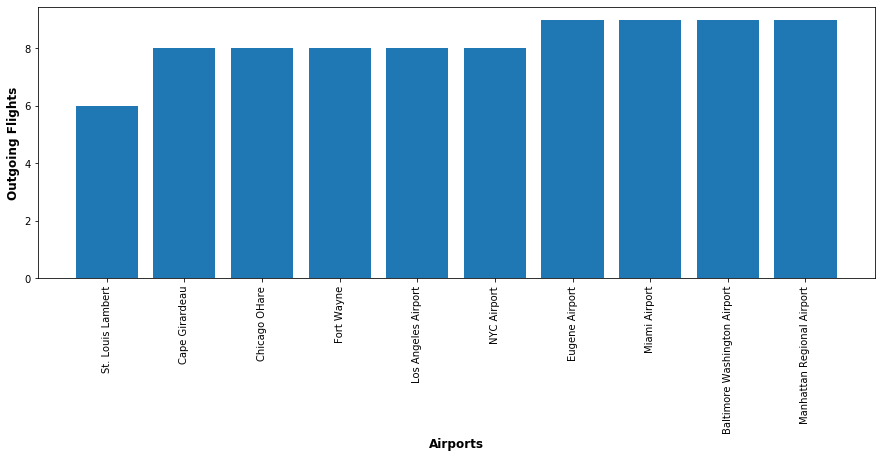

In [30]:
plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Outgoing Flights', fontweight='bold', fontsize='large')
plt.xlabel('Airports', fontweight='bold', fontsize='large');

In [31]:
pandas_df[pandas_df['Outgoing Flights'] == pandas_df['Outgoing Flights'].max()] #there are few equal flights with max departures

,id,Airport Name,Incoming Flights,Outgoing Flights
0,EUG,Eugene Airport,9,9
2,MIA,Miami Airport,7,9
3,BWI,Baltimore Washington Airport,9,9
5,MHK,Manhattan Regional Airport,7,9


<b>Find the airport with the largest number of arriving flight

In [32]:
verticesDF.sort(['Incoming Flights'],ascending=[0]).show()

+---+--------------------+----------------+----------------+
| id|        Airport Name|Incoming Flights|Outgoing Flights|
+---+--------------------+----------------+----------------+
|EUG|      Eugene Airport|               9|               9|
|BWI|Baltimore Washing...|               9|               9|
|STL|   St. Louis Lambert|               9|               6|
|LAX| Los Angeles Airport|               9|               8|
|JFK|         NYC Airport|               9|               8|
|CGI|      Cape Girardeau|               8|               8|
|ORD|       Chicago OHare|               8|               8|
|MHK|Manhattan Regiona...|               7|               9|
|MIA|       Miami Airport|               7|               9|
|FWA|          Fort Wayne|               7|               8|
+---+--------------------+----------------+----------------+



In [33]:
pandas_df = verticesDF.toPandas()  #converting to pandas for better visualization
pandas_df_sorted = pandas_df.sort_values('Incoming Flights')

In [34]:
x = pandas_df_sorted['Airport Name']
y = pandas_df_sorted['Incoming Flights']

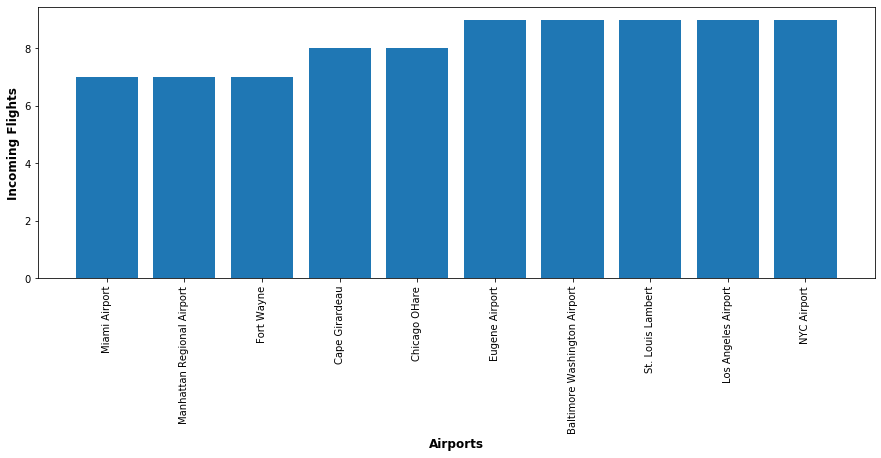

In [35]:
plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Incoming Flights', fontweight='bold', fontsize='large')
plt.xlabel('Airports', fontweight='bold', fontsize='large');

In [36]:
pandas_df[pandas_df['Incoming Flights'] == pandas_df['Incoming Flights'].max()] #there are few equal flights with max arrivals

,id,Airport Name,Incoming Flights,Outgoing Flights
0,EUG,Eugene Airport,9,9
3,BWI,Baltimore Washington Airport,9,9
4,STL,St. Louis Lambert,9,6
8,LAX,Los Angeles Airport,9,8
9,JFK,NYC Airport,9,8


<b>Find the busiest airport

In [37]:
pandas_df['All Flights'] = pandas_df['Incoming Flights'] + pandas_df['Outgoing Flights']

In [38]:
pandas_df_sorted = pandas_df.sort_values('All Flights')

In [39]:
x = pandas_df_sorted['Airport Name']
y = pandas_df_sorted['All Flights']

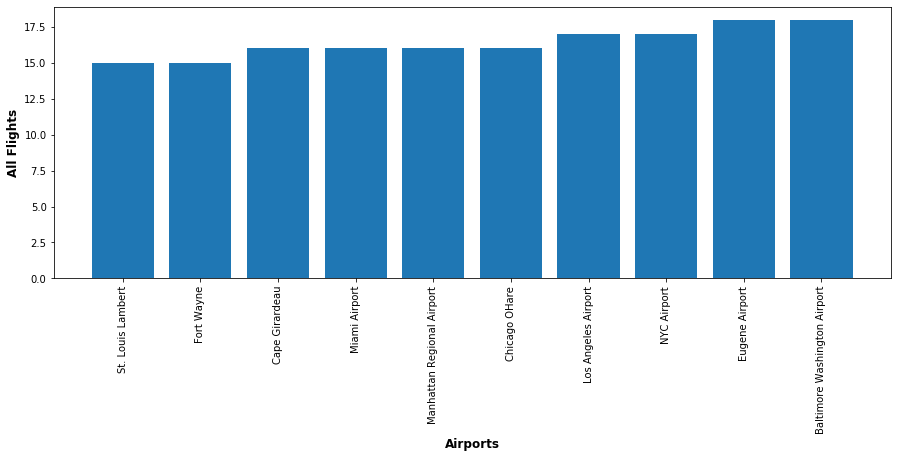

In [40]:
plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('All Flights', fontweight='bold', fontsize='large')
plt.xlabel('Airports', fontweight='bold', fontsize='large');

In [41]:
pandas_df[pandas_df['All Flights'] == pandas_df['All Flights'].max()] #the busiest airports

,id,Airport Name,Incoming Flights,Outgoing Flights,All Flights
0,EUG,Eugene Airport,9,9,18
3,BWI,Baltimore Washington Airport,9,9,18
